In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv("../features/embeddings_using_word2vec.csv").reset_index()
df.tail()

,index,File Number,Sentence Number,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 292,Feature 293,Feature 294,Feature 295,Feature 296,Feature 297,Feature 298,Feature 299,Feature 300,label
12725,12725,969,17,-0.016267,0.235568,0.029791,0.216608,0.067931,-0.385285,0.159128,...,0.248151,0.166786,-0.066317,0.196071,0.284046,0.003565,-0.067389,0.102676,-0.050850,0.083431
12726,12726,969,18,-0.016997,0.264707,0.032498,0.243924,0.065891,-0.430128,0.186655,...,0.275273,0.201370,-0.072022,0.207357,0.316468,0.007688,-0.082683,0.116490,-0.054135,0.179659
12727,12727,969,19,-0.008737,0.109236,0.013941,0.104021,0.027223,-0.183878,0.077781,...,0.118288,0.085592,-0.034953,0.089227,0.131927,0.004654,-0.032595,0.050609,-0.022819,0.115255
12728,12728,969,20,-0.033996,0.480937,0.061682,0.451898,0.133336,-0.795694,0.332466,...,0.513600,0.354607,-0.145264,0.399172,0.579918,0.009967,-0.141316,0.214868,-0.101341,0.073318
12729,12729,969,21,-0.020413,0.297909,0.036816,0.291578,0.072862,-0.501622,0.212426,...,0.316843,0.237501,-0.095403,0.242589,0.356906,0.015378,-0.092694,0.139529,-0.066667,0.124920


# Create graph between sentances using features and cosine similarity

In [8]:
# Generate adjecency matrix for similarity matrix between all the rows
from sklearn.metrics.pairwise import cosine_similarity
def getAdjacencyMatrix(article_df):
    adjacency_matrix = cosine_similarity(article_df.drop(["File Number", "Sentence Number", 'label', 'index'], axis=1))

    # adjacency_matrix[adjacency_matrix>0.5] = 1
    # adjacency_matrix[adjacency_matrix<=0.5] = 0

    # Make top 30% of the values in the adjacency matrix to 1
    adjacency_matrix[adjacency_matrix>np.percentile(adjacency_matrix, 70)] = 1
    adjacency_matrix[adjacency_matrix<=np.percentile(adjacency_matrix, 70)] = 0
    return adjacency_matrix



# convert adj mat to adjacency list
def getEdgeList(article_df, start_node_idx):
    adjacency_matrix = getAdjacencyMatrix(article_df)

    adjacency_list = [[] for _ in range(len(adjacency_matrix))]
    edge_list = []

    for i in range(len(adjacency_matrix)):
        for j in range(i+1, len(adjacency_matrix)):
            if adjacency_matrix[i][j]:
                adjacency_list[i].append(j)
                adjacency_list[j].append(i)
                edge_list.append([start_node_idx + i, start_node_idx + j])

    return edge_list

### Get the edge list for all articles in training data

In [9]:
edge_list = []
node_features = []

total_sentences = 0

# for file_number in train_articles_file_number[:30]:
for file_number in df['File Number'].unique():
    article_df = df[df['File Number'] == file_number]
    article_edge_list = getEdgeList(article_df, total_sentences)
    edge_list.extend(article_edge_list)
    
    total_sentences += article_df.shape[0]
    node_features.extend(article_df.drop(['File Number', 'Sentence Number', 'label', 'index'], axis=1).to_numpy())


In [10]:
edges = np.array(edge_list).T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df.drop(['File Number', 'Sentence Number', 'label', 'index'], axis=1).to_numpy(), dtype=tf.dtypes.float32
)

graph_info = (node_features, edges, edge_weights)

node_features.shape, edges.shape, edge_weights.shape

(TensorShape([12730, 300]), (2, 35188), TensorShape([35188]))

## Plot graph for edge_list of sentences similarity matrix

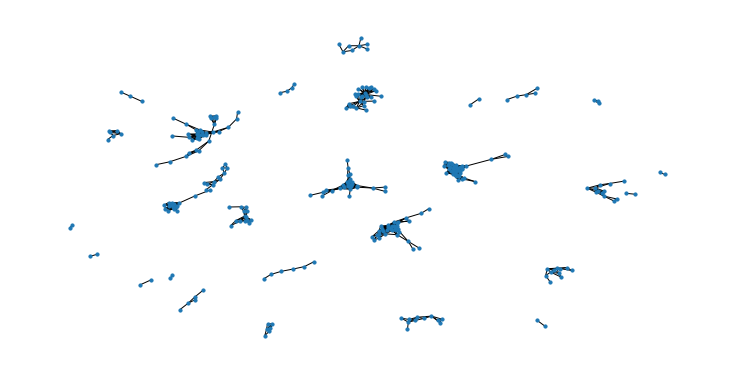

In [11]:
plt.figure(figsize=(10, 5))
sentence_similarity_graph = nx.Graph(edge_list[:1000]) # for first 1000 edges
nx.draw(sentence_similarity_graph, node_size=10)

In [12]:
print(sorted(sentence_similarity_graph.nodes()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 77, 78, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 95, 96, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 121, 124, 127, 128, 129, 130, 131, 132, 139, 140, 141, 142, 143, 146, 148, 149, 151, 152, 153, 163, 164, 165, 166, 167, 169, 170, 171, 172, 174, 176, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 235, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274

# Build a Graph Neural Network Model

Shape of:-

node_features = [num_nodes, num_features]

edges = [2, num_edges]

edge_weights = [num_edges]

### Create a FNN network model

In [13]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu))

    return keras.Sequential(fnn_layers, name=name)

### Graph Conv Layer
- Prepare
- Aggregate
- Update

In [14]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

### Implement a graph neural network node classifier

In [15]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        node_embeddings = self.get_embeddings(input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)
    
    def get_embeddings(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        return tf.gather(x, input_node_indices)



In [16]:
num_features = 100
num_classes = 1
hidden_units = [32, 32]
dropout_rate = 0.2

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100, 1000]))

gnn_model.summary()


GNN output shape: tf.Tensor(
[[-0.07113807]
 [-0.07987157]
 [-0.06684226]
 [-0.07070601]], shape=(4, 1), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (12730, 32)               12016     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (12730, 32)               2368      
                                                                 
 logits (Dense)              multiple                  33        
   

# Split the dataset into train and test sets

In [17]:
train_data, test_data = [], []

for _, group_data in df.groupby("File Number"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (10277, 304)
Test data shape: (2453, 304)


## Train the GNN model

In [18]:
x_train = train_data.index.to_numpy()
y_train = train_data.label.to_numpy()

In [19]:
learning_rate = 0.01
# num_epochs = 300
num_epochs = 10
batch_size = 256

# Compile the model.
gnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", patience=50, restore_best_weights=True
)
# Fit the model.
history = gnn_model.fit(
    x=x_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    callbacks=[early_stopping],
)



Epoch 1/10
35/35 [==============================] - 8s 52ms/step - loss: nan - acc: 2.2896e-04 - val_loss: nan - val_acc: 0.0013
Epoch 2/10
35/35 [==============================] - 1s 28ms/step - loss: nan - acc: 2.2896e-04 - val_loss: nan - val_acc: 0.0013
Epoch 3/10
35/35 [==============================] - 1s 28ms/step - loss: nan - acc: 2.2896e-04 - val_loss: nan - val_acc: 0.0013
Epoch 4/10
35/35 [==============================] - 1s 29ms/step - loss: nan - acc: 2.2896e-04 - val_loss: nan - val_acc: 0.0013
Epoch 5/10
35/35 [==============================] - 1s 30ms/step - loss: nan - acc: 2.2896e-04 - val_loss: nan - val_acc: 0.0013
Epoch 6/10
35/35 [==============================] - 1s 28ms/step - loss: nan - acc: 2.2896e-04 - val_loss: nan - val_acc: 0.0013
Epoch 7/10
35/35 [==============================] - 1s 30ms/step - loss: nan - acc: 2.2896e-04 - val_loss: nan - val_acc: 0.0013
Epoch 8/10
35/35 [==============================] - 1s 29ms/step - loss: nan - acc: 2.2896e-04 - 

### Plot the learning curves

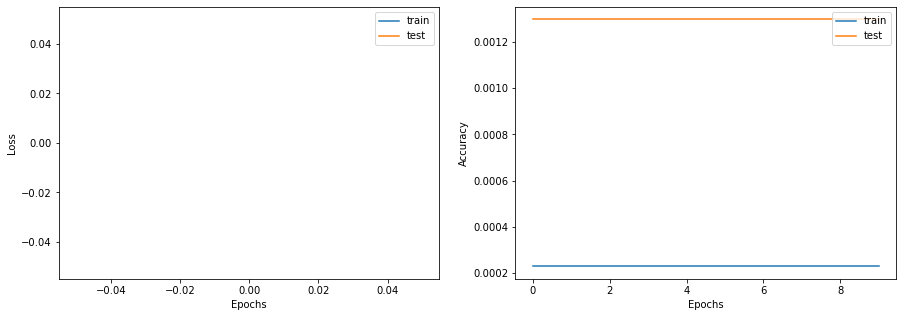

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "test"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.legend(["train", "test"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

## Finding the accuracy of the model on test data

In [21]:
x_test = test_data.index.to_numpy()
y_test = test_data.label.to_numpy()

loss, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
print(f"Loss accuracy: loss")

Test accuracy: 0.0%
Loss accuracy: loss


# Examine the GNN model predictions using rouge scores

To test the model or to get the results for new data, generate a new node features matrix and keep the weight (which we get while training)

To change the node_features

gnn_model.node_features = new_node_features

In [17]:
def page_rank(vector_matrix):
  # cosine_similarity_matrix = cosine_similarity(vector_matrix)
  # distances = 1 - cosine_similarity_matrix
  # distances = np.round(distances.clip(min=0), 2)

  # print(distances)

  # # Adjecency list calucate
  # m = [[] for _ in range(len(distances))]

  # for i in range(len(distances)):
  #   for j in range(len(distances[i])):
  #     if distances[i][j] >= 0.95:
  #       m[i].append(j)

  # # Page rank calculation using custom furmula
  # n = len(m)
  # d, it = .85, 1000
  # rank = [1 for _ in range(n)]

  # # Calculate rank for each iteration
  # for _ in range(it):
  #   for i in range(n):
  #     rank[i] = (1-d) + d * sum([rank[x]/len(m[x]) for x in m[i]])

  # return rank

  aggregate_values = []
  for vector in vector_matrix:
    aggregate_values.append(float(sum(vector)/len(vector)))
  return aggregate_values

In [18]:
generated_summary_index = {} # File Number: [sentence number]

# For each article in test set, generate new embeddings and rank according to page ranking
for file_number, group_data in test_data.groupby("File Number"):
    new_node_index = group_data.index.to_numpy()
    new_node_embeddings = gnn_model.get_embeddings(new_node_index)
    # print(new_node_embeddings)
    sentence_rankings = page_rank(new_node_embeddings)
    # print(sentence_rankings)

    generated_summary_index[file_number] = []
    sentence_rankings = sorted(list(zip(new_node_index, sentence_rankings, group_data['Sentence Number'])), key=lambda x: x[1], reverse=True)
    for index, rank, sentence_number in sentence_rankings[:len(new_node_index)//2]:
        generated_summary_index[file_number].append(sentence_number)
    # break

In [19]:
generated_summary_index

{0: [25, 30, 19, 2],
 2: [9],
 3: [10],
 4: [6],
 5: [],
 7: [],
 8: [10],
 9: [0],
 10: [],
 11: [4],
 12: [],
 13: [2],
 14: [],
 17: [],
 18: [],
 19: [],
 20: [6],
 21: [],
 23: [14, 10, 27, 18],
 24: [13],
 25: [2, 17, 11],
 26: [14, 29, 20, 39, 8, 28],
 27: [2, 8, 6, 17, 3, 35],
 28: [8, 14, 27, 23, 5],
 29: [5],
 30: [9],
 31: [11, 0],
 32: [20, 32, 34, 15],
 33: [9, 18],
 34: [4],
 35: [4],
 37: [6],
 39: [],
 40: [],
 41: [],
 43: [],
 44: [3],
 45: [],
 46: [],
 47: [5],
 48: [6, 0],
 49: [9],
 50: [10, 16, 19],
 51: [11],
 52: [],
 53: [14],
 54: [15],
 55: [7, 9],
 56: [9, 4],
 58: [],
 59: [9, 5],
 60: [4],
 61: [17],
 62: [2],
 63: [3],
 64: [0],
 67: [],
 68: [4],
 69: [],
 70: [2],
 71: [],
 72: [6, 16, 12],
 73: [9, 0],
 74: [10, 3],
 75: [0],
 76: [10],
 77: [8],
 78: [7],
 79: [2],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [6],
 85: [],
 86: [9],
 87: [],
 88: [],
 92: [28, 26, 18, 21, 24],
 94: [],
 96: [2],
 97: [],
 98: [6, 2],
 100: [1],
 102: [],
 103: [2, 10],
 

### Extract the summary with generated sentence number in each article

In [20]:
import nltk
from nltk.corpus import stopwords
from IPython.display import clear_output # to clear the large outputs

In [21]:
# df = pd.read_csv("../EnglishNews_train.csv", encoding="utf-8", nrows=10)
articles_df = pd.read_csv("../newEnglishNews_train.csv", encoding="utf-8", nrows=1000).dropna().reset_index().drop(['index'], axis=1)
articles_df.tail()

,Heading,Summary,Article,id
965,'Sebi Working On Instant Transaction Settlemen...,Sebi chief Madhabi Puri Buch says India is the...,Sebi Chairperson Madhabi Puri Buch on Monday I...,EnglishNews_train_995
966,ICICI Bank Hits Fresh 52-Week High Post Q1 Res...,ICICI Bank Share Price Today: ICICI Bank share...,ICICI Bank Share Price Today: ICICI Bank share...,EnglishNews_train_996
967,Netweb Technologies IPO Share Allotment Today:...,Netweb Technologies is set to finalize the bas...,Netweb Technologies IPO Share Allotment Today:...,EnglishNews_train_997
968,Gold Outperforms Sensex In Past 5 Years Amid G...,Gold Vs Sensex: Gold jumps 99% in the past 5 y...,Gold Vs Sensex In the Past 5 Years: Whenever t...,EnglishNews_train_998
969,"Bears Back in Action! Sensex Tanks 1000 pts, N...",Sensex plunged 800 points to slip below the 67...,Why Are Markets Falling Today? After six strai...,EnglishNews_train_999


In [22]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
clear_output()

def remove_stopwords(text):
    return ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])

In [23]:
generated_summary = {}

for file_number in generated_summary_index:
    sentence_numbers = generated_summary_index[file_number]
    article = articles_df.iloc[file_number, :]['Article']
    sentences = nltk.sent_tokenize(article)

    generated_summary[file_number] = {
        "Generated Summary": "",
        "Given Summary": articles_df.iloc[file_number, :]['Summary']
    }
    for i in sentence_numbers:
        generated_summary[file_number]["Generated Summary"] += sentences[i]


In [24]:
generated_summary

{0: {'Generated Summary': 'That scene and her performance will be discussed in the days to come.Watch the film for the dialogue writing and Margot and Ryan&amp;#8217;s performances.The actress shifts gears from being the happy-go-lucky Barbie to the Barbie no one has ever seen before with utmost ease.Director Greta Gerwig understood these stereotypes and even plays along with them for the first 15 to 20 minutes of the Barbie movie.',
  'Given Summary': 'Barbie Movie Review: Ryan Gosling shines the brightest in the Greta Gerwig film. Margot Robbie proves she was meant for this role.'},
 2: {'Generated Summary': 'View this post on InstagramA post shared by Viral Bhayani (@viralbhayani)Meanwhile, Kartik Aaryan will be soon seen in a romantic drama titled Satyaprem Ki Katha alongside Kiara Advani.',
  'Given Summary': 'Kartik Aaryan was spotted flying in economy class. An Instagram page shared a video of the actor on board an IndiGo flight.'},
 3: {'Generated Summary': 'The government shou

### Save it as a csv file

In [25]:
csv_data_df = pd.DataFrame()
for file_number in generated_summary:
    df = pd.DataFrame({
        "File Number" : [file_number],
        "Generated Summary" : [generated_summary[file_number]['Generated Summary']],
        'Given Summary' : [generated_summary[file_number]['Given Summary']]
    })
    csv_data_df = pd.concat([csv_data_df, df], ignore_index=True)

In [26]:
csv_data_df

,File Number,Generated Summary,Given Summary
0,0,That scene and her performance will be discuss...,Barbie Movie Review: Ryan Gosling shines the b...
1,2,View this post on InstagramA post shared by Vi...,Kartik Aaryan was spotted flying in economy cl...
2,3,The government should get the matter investiga...,Abbasi had said that it was important to make ...
3,4,You can come to enjoy the natural beauty of th...,Flash floods and landslides caused by heavy do...
4,5,,"Anderson turned 41 on Sunday, the fourth day o..."
...,...,...,...
784,964,Tata Steel CEO &amp;amp; MD T V Narendran said...,Tata Steel shares rose after recouping early l...
785,965,With the T+1 trading settlement system from Ja...,Sebi chief Madhabi Puri Buch says India is the...
786,966,ICICI Bank Share Price Today: ICICI Bank share...,ICICI Bank Share Price Today: ICICI Bank share...
787,968,Investors can consider keeping around 20 per c...,Gold Vs Sensex: Gold jumps 99% in the past 5 y...


In [27]:
csv_data_df.to_csv("../features/Generated Summary.csv", index=False)